In [1]:
%config InlineBackend.figure_format = "svg"

from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pennylane as qml

# Search algorithm with a Quantum Variational Circuit

In this notebook, the problem we will be solving is about using a variational circuit that implements a searching algorithm to find marked elements out of a total of $n$ elements, where $n$ is the number of qubits in our circuit. This will be done by using the `Pennylane` library, which natively implements both **parameter-shift rules** and more complex methods for **calculating gradients on quantum hardware**.

To solve this problem, we will apply an ansatz $U(\theta)$ on the input quantum state $|{0}\rangle^{\otimes n}$, where $n$ represents the number of qubits in the quantum circuit.

The goal of the search is to be able to find marked elements $|x^{\star}_k\rangle \in \mathcal{S}$, where $\mathcal{S} \subseteq \mathbb{C}^{2^n}$ and $x^{\star}_ k \in \{0,1\}^N$ is an $N$-bit string, where $n$ represents the number of qubits in our circuit and $N = \left \lceil \log_2(n) \right \rceil$. If we consider $G$ the operator that represents a **general** and **ideal** output of this search algorithm, then we can express it as:
$$ G |0\rangle^{\otimes n} = \frac{1}{\sqrt{|\mathcal{S}|}} \sum_{k=1}^{|\mathcal{S}|} e^{i\varphi_k} |x^{\star}_k\rangle = \sum_{k=1}^{n} |\psi\rangle_k $$

Such that the probability of measuring a final quantum state $| \psi \rangle_k$ is given by:

$$ P \left[ |\psi\rangle_k \right] = \frac{1}{|\mathcal{S}|}, \; \forall | \psi \rangle_k \in \mathcal{S} $$

$$ P \left[ |\psi\rangle_k \right] = 0, \; \forall | \psi_k \rangle \notin \mathcal{S} $$

With a Quantum Variational Circuit with $n$ qubits, where at the output we will have $n$ expectation values (one per output qubit $|\phi\rangle_k$) $f_k(\theta) = {}_k\langle\phi|Z|\phi\rangle_k$ and $Z$ is the Pauli Z gate, we want the output probabilites to match the probabilities of the search's solution. Then, we want the output of our QVC to obey the equation:

$$ \left| f_k(\theta) \right|^2 = P \left[ |\psi\rangle_k \right], \; k = \{1, 2, \dots, n\} $$

Therefore, to learn the parameters $\theta$ of our QVC, we can just minimize a simple *absolute difference loss*:

$$ \min_\theta \mathcal{L}(\theta) = \sum_{k=1}^{n} \left| \left| f_k(\theta) \right|^2 - P \left[ |\psi\rangle_k \right] \right| $$

## Ansatz

The ansatz we will build will follow two guidelines:
- It will be a layered ansatz, which will repeat a certain layer a number of times (an hyperparameter)
- It will be composed only of rotation and CNOT gates, which form an universal unitary group

The gates we will apply in each layer are as follows:
- A `qml.RX`, `qml.RY`, `qml.RZ` and `qml.PhaseShift` parameterized rotation gates, per qubit
- `qml.CNOT` gates for every possible two qubit **combination**

![Ansatz](Images/ansatz.png "Title")

Which means that if $L$ represents the number of layers and $n$ the number of qubits in the circuit, then our ansat'z parameterized weights have a shape $\theta = \left\{ \omega^{(i,j,k)} \; | \; i = \{0,\dots,L-1\}, \; j = \{0,\dots,n-1\}, \; k= \{0,1,2,3\} \right\}$.

Also, for every odd layer number, the order of the *control* and *target* qubits in the `qml.CNOT` gates is flipped

## Defining model hyperparameters

In [2]:
# define quantum device
nr_qubits = 8
dev = qml.device("default.qubit", wires=nr_qubits)

In [3]:
def normalize(vector):
    norm = np.sqrt(np.sum(vector**2))
    return vector / norm

def probabilities(vector):
    nvector = normalize(vector)
    return nvector * np.conj(nvector)

In [4]:
def combinations(values):
    """
    Calculates every possible pair combination of values
    """
    r = []
    for i in range(len(values)):
        for j in range(i+1,len(values)):
            r.append((i,j))
    return r

# a layer of the circuit ansatz
def layer(weights, j):
    for i in range(weights.shape[1]):
        qml.RX(weights[j, i, 0], wires=i)
        qml.RY(weights[j, i, 1], wires=i)
        qml.RZ(weights[j, i, 2], wires=i)

    # Add CNOT for every qubit combination
    combs = combinations(range(weights.shape[1]))
    for i, k in combs:
        if j % 2 == 1:
            i, k = k, i
        qml.CNOT(wires=[i, k])

@qml.qnode(dev)
def qvc(weights):
    # repeatedly apply each layer in the circuit
    for j in range(weights.shape[0]):
        layer(weights, j)

    # returns the expectation of the input matrix A on the first qubit
    measurements = [qml.expval(qml.PauliZ(i)) for i in range(weights.shape[1])]
    return measurements

# cost function
def loss_fn(prediction, label):
    """
    A simple square loss function to evaluate predictions
    """
    pred_prob = probabilities(prediction)
    label_prob = probabilities(label)
    loss = np.sum(np.abs(pred_prob - label_prob))
    return loss

## Defining the training loop for our model

In [5]:
def train(nr_layers, nr_qubits, num_steps, target_qubits):
    # Define model parameters
    weights = np.random.randn(nr_layers, nr_qubits, 3)

    # Defining the target of the circuit's output
    target = np.zeros(nr_qubits)
    target[target_qubits-1] = 1

    # Defining our model's optimizer
    optimizer = qml.AdamOptimizer()

    # Training loop
    best_weights = weights
    best_loss = float("inf")
    losses = []
    fit_tqdm = tqdm(range(num_steps), total=num_steps, desc=f"Fitting {nr_layers}-layer model")
    for _ in fit_tqdm:
        # Calculate the loss of the model
        loss = loss_fn(qvc(weights), target)
        losses.append(loss.item())
        
        # Update model weights
        weights = optimizer.step(lambda v: loss_fn(qvc(v), target), weights)
        
        # Update best loss and weights
        if best_loss > loss.item():
            best_loss = loss.item()
            best_weights = weights
            
        # Print best loss to tqdm bar
        fit_tqdm.set_postfix({"best_loss": best_loss})
        
    results = {"weights": best_weights, "loss": best_loss, "losses": losses}
    return results

In [6]:
# hyperparameters of the training
target_qubits = np.array([1, 5, 7], requires_grad=False)
num_steps = 500

In [7]:
# gather training results
results = {f"{l}-layers": train(l, nr_qubits, num_steps, target_qubits) for l in range(1, 7)}

## Results

### Probabilities

Target Qubits: [1 5 7]


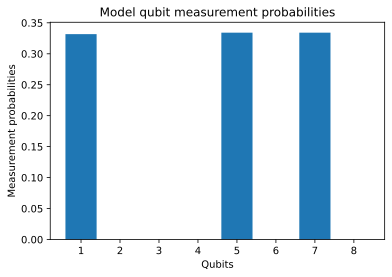

In [9]:
print(f"Target Qubits: {target_qubits}")

# Select the weights to be used
weights = results["4-layers"]["weights"]

# Plot the probabilities
plt.title("Model qubit measurement probabilities")
plt.bar(range(1, nr_qubits+1), probabilities(qvc(weights)))
plt.xlabel("Qubits")
plt.ylabel("Measurement probabilities")
plt.savefig("results/probabilities.png", dpi=300)
plt.show()

### Loss function evolution

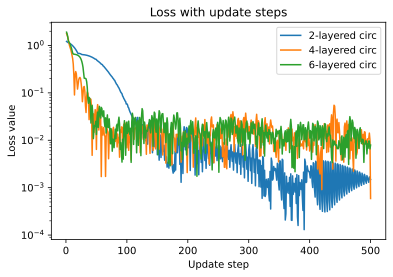

In [21]:
# Select losses to plot
losses = []
for i in range(1, len(results)+1):
    losses.append(results[f"{i}-layers"]["losses"])

# Plot the loss
plt.title("Loss with update steps")
for i in [2, 4, 6]:
    plt.plot(range(1, num_steps+1), losses[i-1], label=f"{i}-layered circ")
plt.xlabel("Update step")
plt.ylabel("Loss value")
plt.yscale("log")
plt.legend()
plt.savefig("results/loss_evolution.png", dpi=300)
plt.show()

### Losses with number of layers

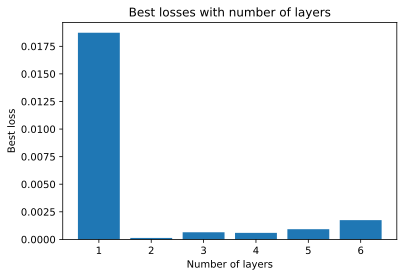

In [20]:
# Get losses from results
losses = [results[key]["loss"] for key in results]

plt.title("Best losses with number of layers")
plt.bar(range(1,7), losses)
plt.xlabel("Number of layers")
plt.ylabel("Best loss")
plt.savefig("results/losses.png", dpi=300)
plt.show()